In [120]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, validation_curve, cross_val_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler

In [61]:
def get_stack_data(name, yval=False):
    if yval:
        yval_string = 'yval_'
    else:
        yval_string = ''
    fold_list = []
    for i in range(1, 6, 1):
        fold = pd.read_csv('./{}_stack/{}_{}fold_{}.csv'.format(name, name, yval_string, i)).as_matrix()
        fold_list.append(fold)

    return fold_list

In [102]:
# Load RF Validation as Features for Layer 2.

rf_stack = get_stack_data('rf')
rf_stack = [x for item in rf_stack for x in item]
rf_stack = pd.DataFrame(rf_stack).drop(0, axis=1)
rf_stack.columns = ['rf_layer']
rf_stack.head()

,rf_layer
0,0.173048
1,0.405546
2,0.353978
3,0.396855
4,0.193455


In [103]:
# Load Logistic Regression Validation as Features for Layer 2.

logit_stack = get_stack_data('logit')
logit_stack = [x for item in logit_stack for x in item]
logit_stack = pd.DataFrame(logit_stack).drop(0, axis=1)
logit_stack.columns = ['logit_layer']
logit_stack.head()

,logit_layer
0,0.173048
1,0.405546
2,0.353978
3,0.396855
4,0.193455


In [104]:
# Load XGB Validation as Features for Layer 2.

xgb_stack = get_stack_data('xgb')
xgb_stack = [x for item in xgb_stack for x in item]
xgb_stack = pd.DataFrame(xgb_stack).drop(0, axis=1)
xgb_stack.columns = ['xgb_layer']
xgb_stack.head()

,xgb_layer
0,0.236785
1,0.402644
2,0.206003
3,0.749326
4,0.219142


In [101]:
# Sanity check to see if the y values match.

y_rf_stack = get_stack_data('rf', True)
y_rf_stack = [x for item in y_rf_stack for x in item]
y_rf_stack = pd.DataFrame(y_rf_stack)
y_rf_stack = pd.DataFrame(y_rf_stack).drop(0, axis=1)
y_rf_stack.columns = ['rf_layer']

y_rf_stack.head()
y_logit_stack = get_stack_data('logit', True)
y_logit_stack = [x for item in y_logit_stack for x in item]
y_logit_stack = pd.DataFrame(y_logit_stack)
y_logit_stack = pd.DataFrame(y_logit_stack).drop(0, axis=1)
y_logit_stack.columns = ['logit_layer']

y_xgb_stack = get_stack_data('xgb', True)
y_xgb_stack = [x for item in y_xgb_stack for x in item]
y_xgb_stack = pd.DataFrame(y_xgb_stack)
y_xgb_stack = pd.DataFrame(y_xgb_stack).drop(0, axis=1)
y_xgb_stack.columns = ['xgb_layer']

print(mean_squared_error(y_rf_stack, y_logit_stack))
print(mean_squared_error(y_xgb_stack, y_logit_stack))
print(mean_squared_error(y_xgb_stack, y_rf_stack))

0.0
0.0
0.0


In [122]:
# Load Test Set.

xgb_test = pd.read_csv('./xgb_stack/xgb_layer_1_test_whole_train_set.csv')
rf_test = pd.read_csv('./rf_stack/rf_layer_1_test_50_8_5.csv')
logit_test = pd.read_csv('./logit_stack/logit_layer_1_test_l2_sag_C15.csv')

In [81]:
def five_fold_train(x, y, model, name='model', folds=5):
    ''' Function for Generate Five Fold Stacking Features '''
    x_train_scaled = MinMaxScaler().fit_transform(x)
    skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

    fold_count = 1
    for train_index, val_index in skf.split(x_train_scaled, y):
        print('Folds: ', fold_count)

        # Training...
        logit.fit(x_train_scaled[train_index], y[train_index])

        # Validating. Layer 2 training features...
        val = logit.predict_proba(x_train_scaled[val_index])
        val = pd.DataFrame(val).drop(0, axis=1)
        y_val = y[val_index]

        print('Validation Error: ', log_loss(y_val, val))
        fold_count = fold_count + 1

In [117]:
%%time

feats = pd.concat([rf_stack, logit_stack, xgb_stack], axis=1)
logit_layer2 = LogisticRegression()
train_scores, valid_scores = validation_curve(logit_layer2, \
                                              feats, \
                                              y_logit_stack['logit_layer'], \
                                              "C", \
                                              range(1, 200, 20), \
                                              cv=3, \
                                              scoring='neg_log_loss', \
                                              n_jobs=1)

CPU times: user 22.3 s, sys: 3.14 s, total: 25.4 s
Wall time: 25.8 s


[-0.25735797 -0.25937247 -0.25824278]


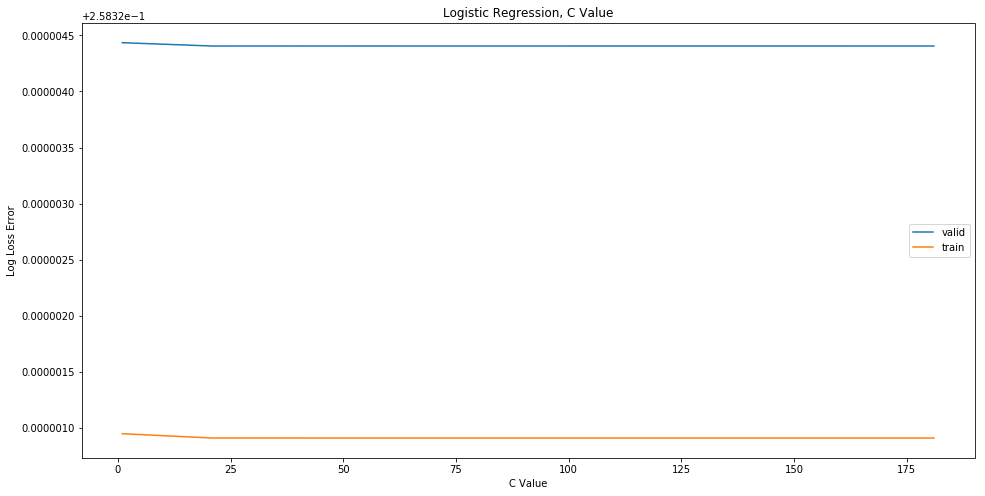

In [147]:
# Plot the learning curve from the above result.

valid_scores_mean = -1*np.mean(valid_scores, axis=1)
train_scores_mean = -1*np.mean(train_scores, axis=1)

plt.figure(figsize=(16, 8))
plt.plot(range(1, 200, 20), valid_scores_mean, label='valid')
plt.plot(range(1, 200, 20), train_scores_mean, label='train')
plt.title('Logistic Regression, C Value')

plt.xlabel('C Value')
plt.ylabel('Log Loss Error')
plt.legend()
print(cross_val_score(logit_layer2, feats, y_logit_stack['logit_layer'], scoring='neg_log_loss'))

In [130]:
rf_test = rf_test.drop('test_id', axis=1)
logit_test = logit_test.drop('test_id', axis=1)
xgb_test = xgb_test.drop('test_id', axis=1)

test_feats = pd.concat([rf_test, logit_test, xgb_test], axis=1)

In [144]:
logit_layer2.fit(feats, y_logit_stack)
logit_pred = logit_layer2.predict_proba(test_feats)
pd.DataFrame(logit_pred)[1]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0          0.027331
1          0.474785
2          0.077004
3          0.026392
4          0.090421
5          0.027889
6          0.982213
7          0.083253
8          0.285657
9          0.026192
10         0.356719
11         0.025623
12         0.025513
13         0.111605
14         0.034936
15         0.050272
16         0.026142
17         0.561478
18         0.229208
19         0.190768
20         0.025455
21         0.027225
22         0.026179
23         0.031591
24         0.026215
25         0.125581
26         0.025828
27         0.027737
28         0.070751
29         0.025809
             ...   
2345766    0.025546
2345767    0.026185
2345768    0.037658
2345769    0.025615
2345770    0.070597
2345771    0.819331
2345772    0.239695
2345773    0.039038
2345774    0.027787
2345775    0.219663
2345776    0.053693
2345777    0.045960
2345778    0.026227
2345779    0.027550
2345780    0.026035
2345781    0.084529
2345782    0.085068
2345783    0.025432
2345784    0.131477


In [145]:
submission = pd.DataFrame()
submission['test_id'] = xgb_test.index.values
submission['is_duplicate'] = pd.DataFrame(logit_pred)[1]
submission.to_csv('stacked_xgb_rf_logit.csv', index=False)

In [146]:
submission.shape

(2345796, 2)